In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [8]:
healthy_df = df[(df['samples_per_second'] == 12000) & (df['fault'] == 0)]
faulty_df = df[(df['samples_per_second'] == 12000) & (df['fault'] == 1)]

In [9]:
import numpy as np
from typing import List, Tuple, Optional

# ---- optional SciPy acceleration (auto-detected) ----
try:
    from scipy.interpolate import CubicSpline
    _HAVE_SCIPY_SPLINE = True
except Exception:
    _HAVE_SCIPY_SPLINE = False

try:
    from scipy.signal import hilbert as _scipy_hilbert
    _HAVE_SCIPY_HILBERT = True
except Exception:
    _HAVE_SCIPY_HILBERT = False


def _hilbert_analytic(x: np.ndarray) -> np.ndarray:
    """
    Analytic signal via Hilbert transform.
    Uses SciPy if available; otherwise FFT-based construction.
    x: (..., N)
    returns: complex analytic signal with same shape
    """
    if _HAVE_SCIPY_HILBERT:
        return _scipy_hilbert(x, axis=-1)

    # FFT-based Hilbert transform (last axis)
    Xf = np.fft.fft(x, axis=-1)
    N = x.shape[-1]
    h = np.zeros(N)
    if N % 2 == 0:
        h[0] = 1
        h[N // 2] = 1
        h[1:N // 2] = 2
    else:
        h[0] = 1
        h[1:(N + 1) // 2] = 2
    return np.fft.ifft(Xf * h, axis=-1)


def _find_extrema(h: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return indices of local maxima and minima for a 1D signal h.
    """
    dh = np.diff(h)
    # avoid plateaus: treat zeros by nudging with tiny noise-free rule
    # compute sign of derivative; treat zeros by carrying nearest nonzero sign
    sign = np.sign(dh)
    # propagate last nonzero sign across zeros
    nz = np.nonzero(sign)[0]
    if len(nz) > 0:
        last = nz[0]
        for i in range(len(sign)):
            if sign[i] == 0:
                sign[i] = sign[last]
            else:
                last = i
    # extrema where derivative changes sign
    max_idx = np.where((sign[:-1] > 0) & (sign[1:] < 0))[0] + 1
    min_idx = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0] + 1
    return max_idx, min_idx


def _zero_crossings(h: np.ndarray) -> int:
    s = np.sign(h)
    # treat zeros as small numbers to stabilize counting
    s[s == 0] = 1
    return np.sum(s[:-1] * s[1:] < 0)


class EMD:
    """
    Minimal Empirical Mode Decomposition with linear envelopes (NumPy-only).
    If SciPy is available, uses cubic splines for smoother envelopes.

    Parameters
    ----------
    max_imfs : int or None
        Maximum number of IMFs to extract (None -> until residual has <2 extrema).
    max_siftings : int
        Max sifting iterations per IMF.
    sd_thresh : float
        Stopping threshold on normalized squared difference (Huang's SD).
    envelope_bc : {'auto','linear','cubic'}
        Envelope interpolation mode. 'auto' -> 'cubic' if SciPy available else 'linear'.
    mean_tol_ratio : float
        Additional stop: mean-envelope magnitude relative to signal RMS.
    """
    def __init__(self,
                 max_imfs: Optional[int] = None,
                 max_siftings: int = 50,
                 sd_thresh: float = 0.2,
                 envelope_bc: str = 'auto',
                 mean_tol_ratio: float = 0.05):
        self.max_imfs = max_imfs
        self.max_siftings = max_siftings
        self.sd_thresh = sd_thresh
        self.mean_tol_ratio = mean_tol_ratio
        if envelope_bc == 'auto':
            self.envelope_mode = 'cubic' if _HAVE_SCIPY_SPLINE else 'linear'
        else:
            self.envelope_mode = envelope_bc

    def _interp_envelope(self, t: np.ndarray, h: np.ndarray, idx: np.ndarray) -> Optional[np.ndarray]:
        """
        Build upper/lower envelope through extrema indices.
        Linear by default; cubic if SciPy available and selected.
        Extends to endpoints by holding first/last extrema values.
        """
        n = len(h)
        if idx.size < 2:
            return None

        # ensure endpoints present (simple hold extension)
        if idx[0] != 0:
            idx = np.r_[0, idx]
            vals = np.r_[h[idx[1]], h[idx[1:]]]
        else:
            vals = h[idx]
        if idx[-1] != n - 1:
            idx = np.r_[idx, n - 1]
            vals = np.r_[vals, vals[-1]]

        # ensure strict monotonicity in idx for cubic
        uniq_idx, uniq_pos = np.unique(idx, return_index=True)
        vals = vals[uniq_pos]

        if self.envelope_mode == 'cubic' and _HAVE_SCIPY_SPLINE and uniq_idx.size >= 3:
            cs = CubicSpline(t[uniq_idx], vals, bc_type='natural', extrapolate=True)
            return cs(t)
        else:
            return np.interp(t, t[uniq_idx], vals)

    def _extract_one_imf(self, t: np.ndarray, r: np.ndarray) -> Tuple[np.ndarray, bool]:
        """
        Sift residual r to extract one IMF. Returns (imf, success_flag)
        """
        h = r.copy()
        for _ in range(self.max_siftings):
            max_idx, min_idx = _find_extrema(h)
            if max_idx.size < 2 or min_idx.size < 2:
                # cannot form envelopes — stop
                return h, False

            env_max = self._interp_envelope(t, h, max_idx)
            env_min = self._interp_envelope(t, h, min_idx)
            if env_max is None or env_min is None:
                return h, False
            m = 0.5 * (env_max + env_min)
            h_new = h - m

            # SD stopping criterion
            denom = np.sum(h ** 2) + 1e-15
            sd = np.sum((h - h_new) ** 2) / denom

            # IMF property checks
            nz = _zero_crossings(h_new)
            ne = _find_extrema(h_new)[0].size + _find_extrema(h_new)[1].size
            imf_like = abs(ne - nz) <= 1
            mean_small = (np.mean(np.abs(m)) <= self.mean_tol_ratio * (np.sqrt(denom / len(h))))

            h = h_new
            if sd < self.sd_thresh and imf_like and mean_small:
                return h, True

        # reached max sifts — accept best effort
        return h, True

    def decompose(self, x: np.ndarray, t: Optional[np.ndarray] = None) -> Tuple[List[np.ndarray], np.ndarray]:
        """
        Decompose x into IMFs and residual.
        """
        x = np.asarray(x).astype(float)
        n = len(x)
        if t is None:
            t = np.arange(n, dtype=float)

        imfs = []
        r = x.copy()
        imf_count = 0
        while True:
            max_idx, min_idx = _find_extrema(r)
            if (max_idx.size + min_idx.size) < 2:  # no meaningful oscillation left
                break
            if self.max_imfs is not None and imf_count >= self.max_imfs:
                break

            imf, ok = self._extract_one_imf(t, r)
            imfs.append(imf)
            r = r - imf
            imf_count += 1
            if not ok:
                break

        return imfs, r


class HHT(EMD):
    """
    HHT = EMD + Hilbert spectral analysis (instantaneous amplitude & frequency).
    """
    @staticmethod
    def hilbert_analysis(imfs: List[np.ndarray], fs: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Compute analytic signal, amplitude, phase, and instantaneous frequency for each IMF.

        Returns
        -------
        amp : (K, N) instantaneous amplitude
        phase : (K, N) unwrapped phase [rad]
        freq : (K, N) instantaneous frequency [Hz]
        """
        if len(imfs) == 0:
            return (np.empty((0, 0)), np.empty((0, 0)), np.empty((0, 0)))
        X = np.stack(imfs, axis=0)  # (K, N)
        z = _hilbert_analytic(X)    # analytic signal
        amp = np.abs(z)
        phase = np.unwrap(np.angle(z), axis=-1)
        # derivative of phase -> angular frequency -> Hz
        dphi = np.gradient(phase, axis=-1)
        omega = dphi * fs
        freq = omega / (2 * np.pi)
        return amp, phase, freq

    def transform(self, x: np.ndarray, fs: float, t: Optional[np.ndarray] = None):
        """
        Convenience: do EMD then Hilbert analysis.

        Returns dict with keys:
        - 'imfs': list of IMFs
        - 'residual': residual signal
        - 'amplitude': (K, N)
        - 'phase': (K, N)
        - 'frequency': (K, N) in Hz
        """
        imfs, r = self.decompose(x, t)
        amp, phase, freq = self.hilbert_analysis(imfs, fs)
        return dict(imfs=imfs, residual=r, amplitude=amp, phase=phase, frequency=freq)

In [20]:
# ------------------------- Example usage -------------------------
if __name__ == "__main__":
    # Synthetic AM-FM test signal
    x = healthy_df.loc[:999, 'DE'].values
    fs = healthy_df['samples_per_second'][0]  # Hz
    N = 1000
    t = np.arange(N) / fs

    # component 1: 8 Hz with slow AM
    #c1 = (1.0 + 0.3 * np.sin(2 * np.pi * 0.2 * t)) * np.sin(2 * np.pi * 8.0 * t)
    # component 2: chirp-like component (frequency increases)
    #c2 = 0.6 * np.sin(2 * np.pi * (2.0 * t + 0.001 * (t ** 2)))
    # component 3: higher frequency
    #c3 = 0.3 * np.sin(2 * np.pi * 30.0 * t)
    #x = c1 + c2 + c3 + 0.05 * np.random.randn(N)

    hht = HHT(max_imfs=6, max_siftings=100, sd_thresh=0.2, envelope_bc='auto')
    result = hht.transform(x, fs, t)

    imfs = result["imfs"]
    residual = result["residual"]
    amp = result["amplitude"]
    freq = result["frequency"]

    print(f"Extracted {len(imfs)} IMFs")
    for i, imf in enumerate(imfs, 1):
        print(f"IMF {i}: std={np.std(imf):.4f}, length={len(imf)}")
    print(f"Residual std: {np.std(residual):.4f}")

    # Example: average instantaneous frequency per IMF (ignoring edges)
    if freq.size:
        mean_freqs = np.nanmean(freq[:, 10:-10], axis=1)
        for i, mf in enumerate(mean_freqs, 1):
            print(f"Mean inst. freq of IMF {i}: {mf:.2f} Hz")

Extracted 6 IMFs
IMF 1: std=0.0335, length=1000
IMF 2: std=0.0300, length=1000
IMF 3: std=0.0278, length=1000
IMF 4: std=0.0287, length=1000
IMF 5: std=0.0261, length=1000
IMF 6: std=0.0113, length=1000
Residual std: 0.0027
Mean inst. freq of IMF 1: 2077.93 Hz
Mean inst. freq of IMF 2: 963.96 Hz
Mean inst. freq of IMF 3: 424.20 Hz
Mean inst. freq of IMF 4: 191.33 Hz
Mean inst. freq of IMF 5: 85.09 Hz
Mean inst. freq of IMF 6: 35.94 Hz


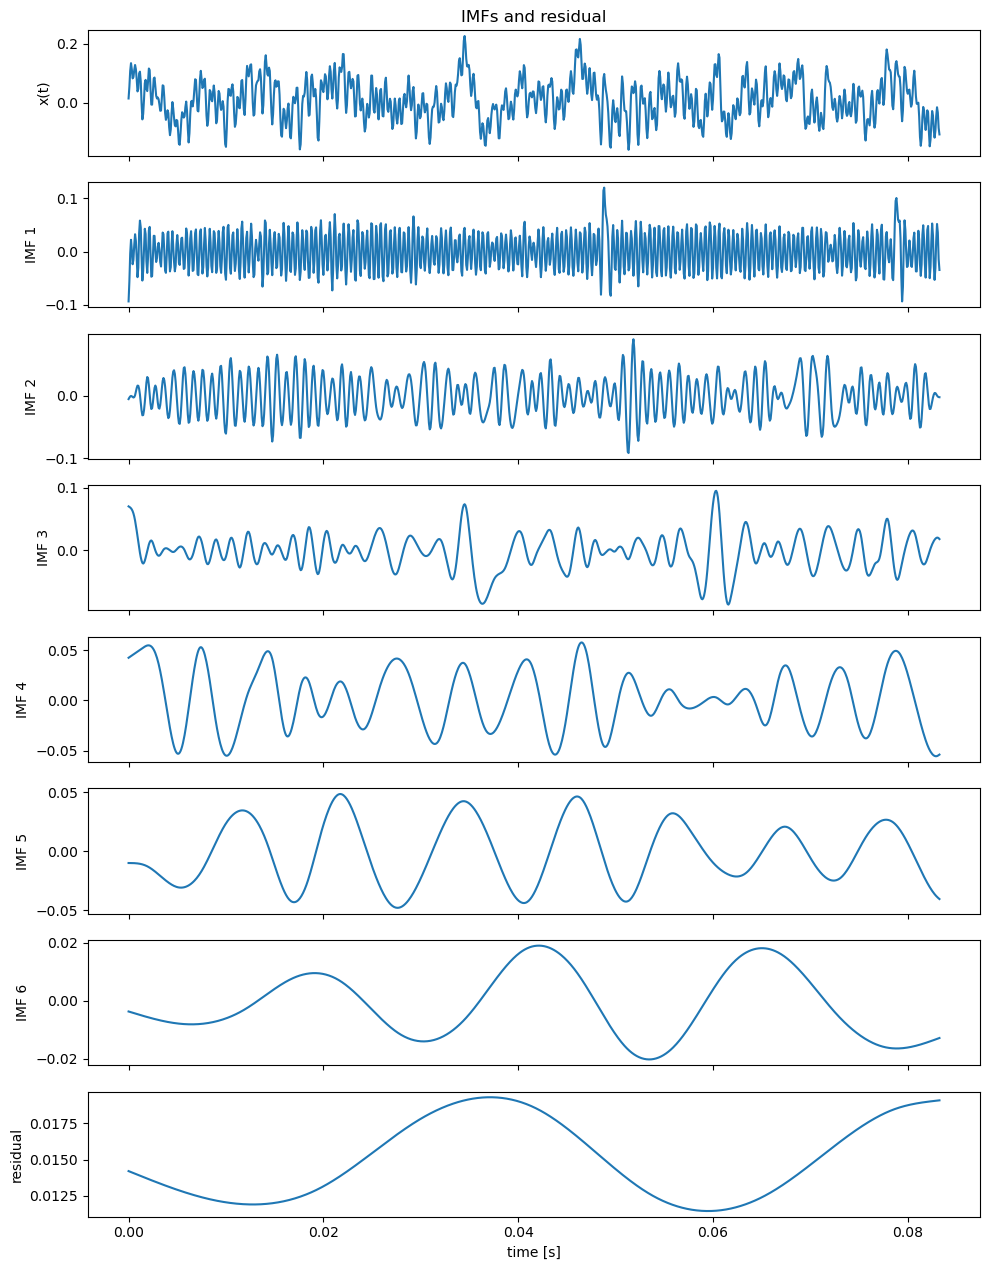

In [21]:
import matplotlib.pyplot as plt

K = len(imfs)
rows = K + 1 + (1 if residual is not None else 0)
fig, axs = plt.subplots(rows, 1, figsize=(10, 1.6*rows), sharex=True)
axs = np.atleast_1d(axs)

axs[0].plot(t, x)
axs[0].set_ylabel("x(t)")
axs[0].set_title('IMFs and residual')

for i, imf in enumerate(imfs, start=1):
    axs[i].plot(t, imf)
    axs[i].set_ylabel(f"IMF {i}")

if residual is not None:
    axs[-1].plot(t, residual)
    axs[-1].set_ylabel("residual")

axs[-1].set_xlabel("time [s]")
fig.tight_layout()
plt.show()

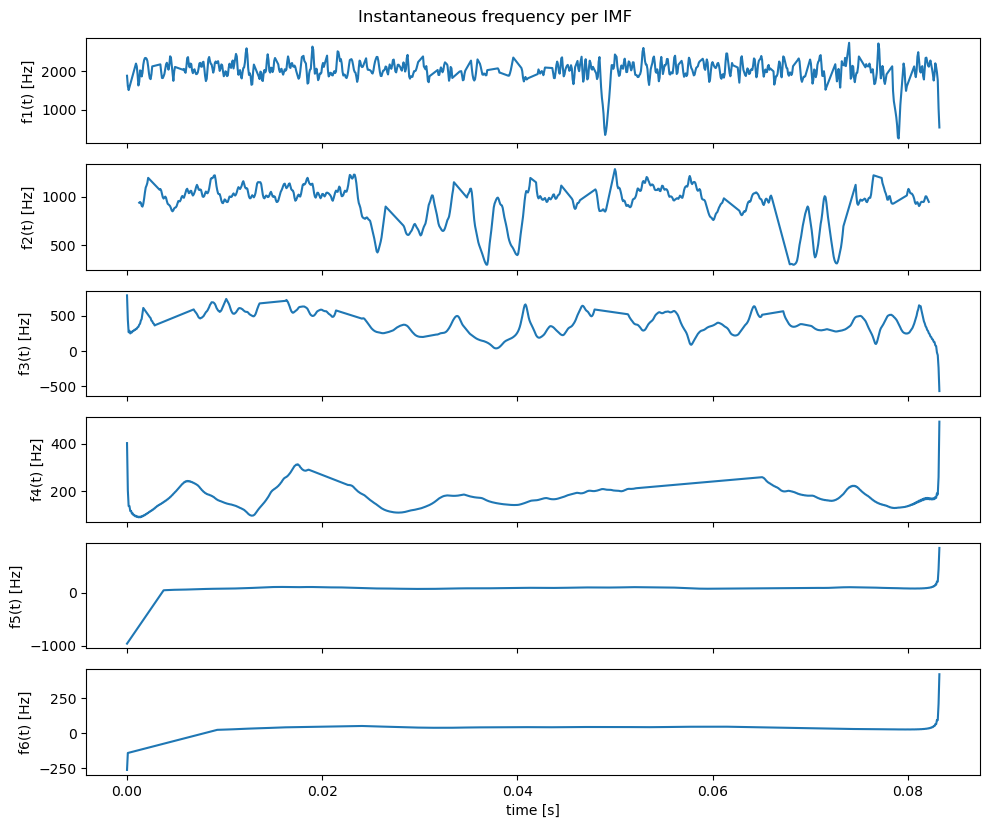

In [22]:
fmax = None
K, N = freq.shape
rows = K
fig, axs = plt.subplots(rows, 1, figsize=(10, 1.4*rows), sharex=True)
axs = np.atleast_1d(axs)

for k in range(K):
    f = freq[k]
    if fmax is not None:
        f = np.clip(f, 0, fmax)
    if amp is not None:
        # light mask to reduce noisy edges/low amplitude artifacts
        mask = amp[k] > (np.percentile(amp[k], 20))
        axs[k].plot(t[mask], f[mask])
    else:
        axs[k].plot(t, f)
    axs[k].set_ylabel(f"f{ k+1 }(t) [Hz]")
axs[-1].set_xlabel("time [s]")
fig.suptitle('Instantaneous frequency per IMF')
fig.tight_layout()
plt.show()

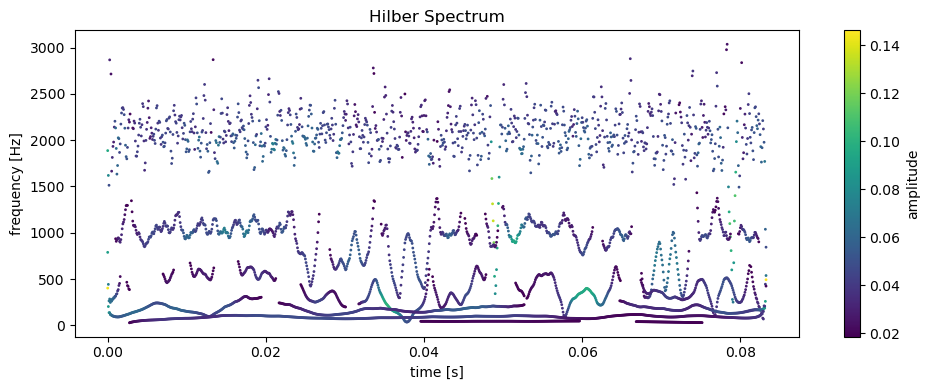

In [23]:
K, N = freq.shape
T = np.tile(t, (K, 1))
F = freq.copy()
A = amp.copy()

if fmax is not None:
    mask = (F >= 0) & (F <= fmax)
    T, F, A = T[mask], F[mask], A[mask]
else:
    mask = (F >= 0)
    T, F, A = T[mask], F[mask], A[mask]

if A.size == 0:
    print("Nothing to plot (check masks).")

thr = np.percentile(A, 20)
m2 = A >= thr
T, F, A = T[m2], F[m2], A[m2]

plt.figure(figsize=(10, 4))
sc = plt.scatter(T, F, c=A, s=1, cmap="viridis")
plt.xlabel("time [s]")
plt.ylabel("frequency [Hz]")
plt.title('Hilber Spectrum')
cbar = plt.colorbar(sc)
cbar.set_label("amplitude")
plt.tight_layout()
plt.show()

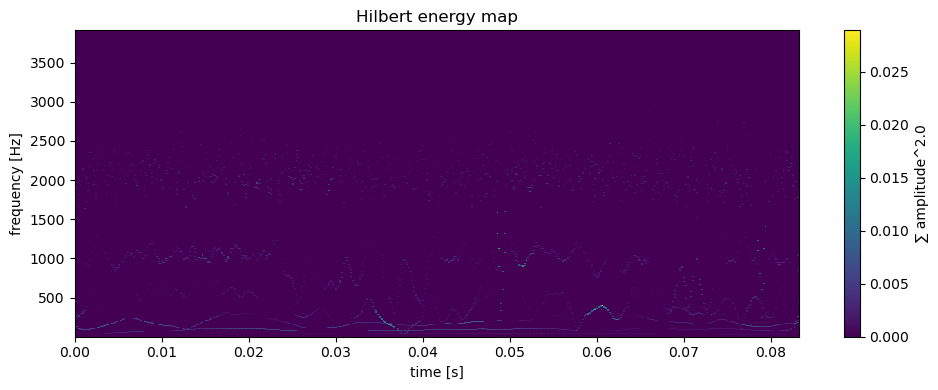

In [24]:
K, N = freq.shape
T = np.tile(t, (K, 1)).ravel()
F = freq.ravel()
W = (amp**2.0).ravel()

# mask to valid band
if fmax is not None:
    m = (F >= 0) & (F <= fmax)
else:
    m = (F >= 0)

T, F, W = T[m], F[m], W[m]

# build 2D histogram
H, t_edges, f_edges = np.histogram2d(T, F, bins=[400, 400], weights=W)
Tm = 0.5*(t_edges[:-1] + t_edges[1:])
Fm = 0.5*(f_edges[:-1] + f_edges[1:])

plt.figure(figsize=(10, 4))
plt.pcolormesh(Tm, Fm, H.T, shading="auto")
plt.xlabel("time [s]")
plt.ylabel("frequency [Hz]")
plt.title('Hilbert energy map')
cbar = plt.colorbar()
cbar.set_label(f"∑ amplitude^{2.0}")
plt.tight_layout()
plt.show()

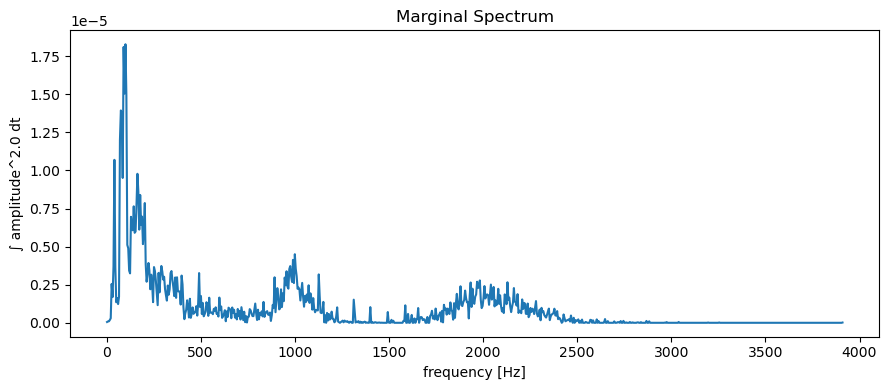

In [25]:
K, N = freq.shape
# tile time steps for all IMFs; approximate Δt from t
dt = np.median(np.diff(t))
F = freq.ravel()
W = (amp**2.0).ravel() * dt  # integrate over time

if fmax is not None:
    m = (F >= 0) & (F <= fmax)
else:
    m = (F >= 0)
F, W = F[m], W[m]

H, f_edges = np.histogram(F, bins=800, weights=W)
Fm = 0.5*(f_edges[:-1] + f_edges[1:])

plt.figure(figsize=(9, 4))
plt.plot(Fm, H)
plt.xlabel("frequency [Hz]")
plt.ylabel(f"∫ amplitude^{2.0} dt")
plt.title('Marginal Spectrum')
plt.tight_layout()
plt.show()

In [35]:
faulty_df[(faulty_df['fault_diameter']==28) & (faulty_df['fault_element'] == 2)]

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
2072887,-6.558414,NaN,28,3,1730,1,12000,2,1
2072888,4.061676,NaN,28,3,1730,1,12000,2,1
2072889,7.613099,NaN,28,3,1730,1,12000,2,1
2072890,-2.233067,NaN,28,3,1730,1,12000,2,1
2072891,-6.915672,NaN,28,3,1730,1,12000,2,1
...,...,...,...,...,...,...,...,...,...
2193866,3.383780,NaN,28,3,1730,1,12000,2,1
2193867,-0.202636,NaN,28,3,1730,1,12000,2,1
2193868,-3.315421,NaN,28,3,1730,1,12000,2,1
2193869,-0.596515,NaN,28,3,1730,1,12000,2,1


In [31]:
faulty_df['samples_per_second'].reset_index(drop=True)[0]

12000

In [60]:
# ------------------------- Example usage -------------------------
if __name__ == "__main__":
    # Synthetic AM-FM test signal
    x = faulty_df[(faulty_df['fault_diameter']==28) & (faulty_df['fault_element'] == 2)].reset_index(drop=True).loc[:999, 'DE'].values
    fs = faulty_df['samples_per_second'].reset_index(drop=True)[0]  # Hz
    N = 1000
    t = np.arange(N) / fs

    # component 1: 8 Hz with slow AM
    #c1 = (1.0 + 0.3 * np.sin(2 * np.pi * 0.2 * t)) * np.sin(2 * np.pi * 8.0 * t)
    # component 2: chirp-like component (frequency increases)
    #c2 = 0.6 * np.sin(2 * np.pi * (2.0 * t + 0.001 * (t ** 2)))
    # component 3: higher frequency
    #c3 = 0.3 * np.sin(2 * np.pi * 30.0 * t)
    #x = c1 + c2 + c3 + 0.05 * np.random.randn(N)

    hht_faulty = HHT(max_imfs=6, max_siftings=100, sd_thresh=0.2, envelope_bc='auto')
    result_faulty = hht_faulty.transform(x, fs, t)

    imfs_faulty = result_faulty["imfs"]
    residual_faulty = result_faulty["residual"]
    amp_faulty = result_faulty["amplitude"]
    freq_faulty = result_faulty["frequency"]

    print(f"Extracted {len(imfs_faulty)} IMFs")
    for i, imf_f in enumerate(imfs_faulty, 1):
        print(f"IMF {i}: std={np.std(imf_f):.4f}, length={len(imf_f)}")
    print(f"Residual std: {np.std(residual_faulty):.4f}")

    # Example: average instantaneous frequency per IMF (ignoring edges)
    if freq_faulty.size:
        mean_freqs = np.nanmean(freq_faulty[:, 10:-10], axis=1)
        for i, mf in enumerate(mean_freqs, 1):
            print(f"Mean inst. freq of IMF {i}: {mf:.2f} Hz")

Extracted 6 IMFs
IMF 1: std=2.1479, length=1000
IMF 2: std=0.1026, length=1000
IMF 3: std=0.0558, length=1000
IMF 4: std=0.0320, length=1000
IMF 5: std=0.0141, length=1000
IMF 6: std=0.0125, length=1000
Residual std: 0.0173
Mean inst. freq of IMF 1: 3072.64 Hz
Mean inst. freq of IMF 2: 1401.46 Hz
Mean inst. freq of IMF 3: 662.21 Hz
Mean inst. freq of IMF 4: 273.22 Hz
Mean inst. freq of IMF 5: 156.90 Hz
Mean inst. freq of IMF 6: 83.84 Hz


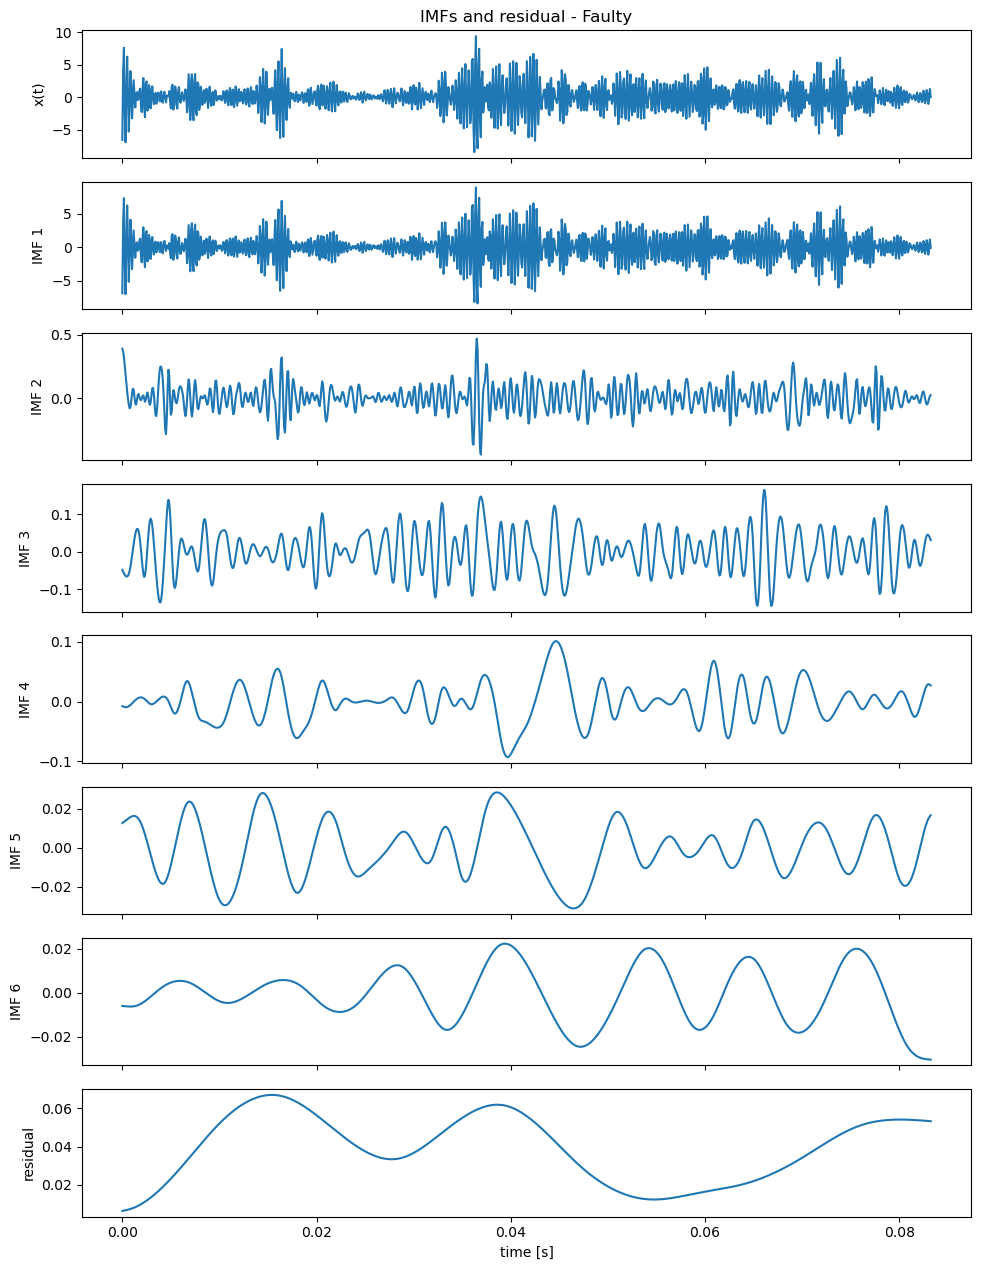

In [61]:
import matplotlib.pyplot as plt

K = len(imfs_faulty)
rows = K + 1 + (1 if residual_faulty is not None else 0)
fig, axs = plt.subplots(rows, 1, figsize=(10, 1.6*rows), sharex=True)
axs = np.atleast_1d(axs)

axs[0].plot(t, x)
axs[0].set_ylabel("x(t)")
axs[0].set_title('IMFs and residual - Faulty')

for i, imf in enumerate(imfs_faulty, start=1):
    axs[i].plot(t, imf)
    axs[i].set_ylabel(f"IMF {i}")

if residual_faulty is not None:
    axs[-1].plot(t, residual_faulty)
    axs[-1].set_ylabel("residual")

axs[-1].set_xlabel("time [s]")
fig.tight_layout()
plt.show()

In [43]:
df_48k_faulty = df[(df['samples_per_second']==48000) & (df['fault'] == 1) & (df['fault_element'] == 2) & (df['fault_end'] == 2) & (df['fault_diameter'] == 21)]

In [57]:
# ------------------------- Example usage -------------------------
if __name__ == "__main__":
    # Synthetic AM-FM test signal
    x_faulty = df_48k_faulty.reset_index(drop=True).loc[:999, 'FE']
    fs = 48000  # Hz
    N = 1000
    t = np.arange(N) / fs

    # component 1: 8 Hz with slow AM
    #c1 = (1.0 + 0.3 * np.sin(2 * np.pi * 0.2 * t)) * np.sin(2 * np.pi * 8.0 * t)
    # component 2: chirp-like component (frequency increases)
    #c2 = 0.6 * np.sin(2 * np.pi * (2.0 * t + 0.001 * (t ** 2)))
    # component 3: higher frequency
    #c3 = 0.3 * np.sin(2 * np.pi * 30.0 * t)
    #x = c1 + c2 + c3 + 0.05 * np.random.randn(N)

    hht_faulty = HHT(max_imfs=6, max_siftings=100, sd_thresh=0.2, envelope_bc='auto')
    result_faulty = hht_faulty.transform(x_faulty, fs, t)

    imfs_faulty = result_faulty["imfs"]
    residual_faulty = result_faulty["residual"]
    amp_faulty = result_faulty["amplitude"]
    freq_faulty = result_faulty["frequency"]

    print(f"Extracted {len(imfs_faulty)} IMFs")
    for i, imf_f in enumerate(imfs_faulty, 1):
        print(f"IMF {i}: std={np.std(imf_f):.4f}, length={len(imf_f)}")
    print(f"Residual std: {np.std(residual_faulty):.4f}")

    # Example: average instantaneous frequency per IMF (ignoring edges)
    if freq_faulty.size:
        mean_freqs = np.nanmean(freq_faulty[:, 10:-10], axis=1)
        for i, mf in enumerate(mean_freqs, 1):
            print(f"Mean inst. freq of IMF {i}: {mf:.2f} Hz")

Extracted 6 IMFs
IMF 1: std=0.1370, length=1000
IMF 2: std=0.0642, length=1000
IMF 3: std=0.0293, length=1000
IMF 4: std=0.0244, length=1000
IMF 5: std=0.0177, length=1000
IMF 6: std=0.0043, length=1000
Residual std: 0.0062
Mean inst. freq of IMF 1: 13919.71 Hz
Mean inst. freq of IMF 2: 5098.75 Hz
Mean inst. freq of IMF 3: 2565.88 Hz
Mean inst. freq of IMF 4: 1116.95 Hz
Mean inst. freq of IMF 5: 534.99 Hz
Mean inst. freq of IMF 6: 283.70 Hz


In [58]:
x_faulty

0     -0.304464
1     -0.124387
2      0.259343
3     -0.067478
4     -0.088209
         ...   
995    0.310155
996   -0.130891
997    0.302025
998    0.409339
999   -0.215035
Name: FE, Length: 1000, dtype: float64

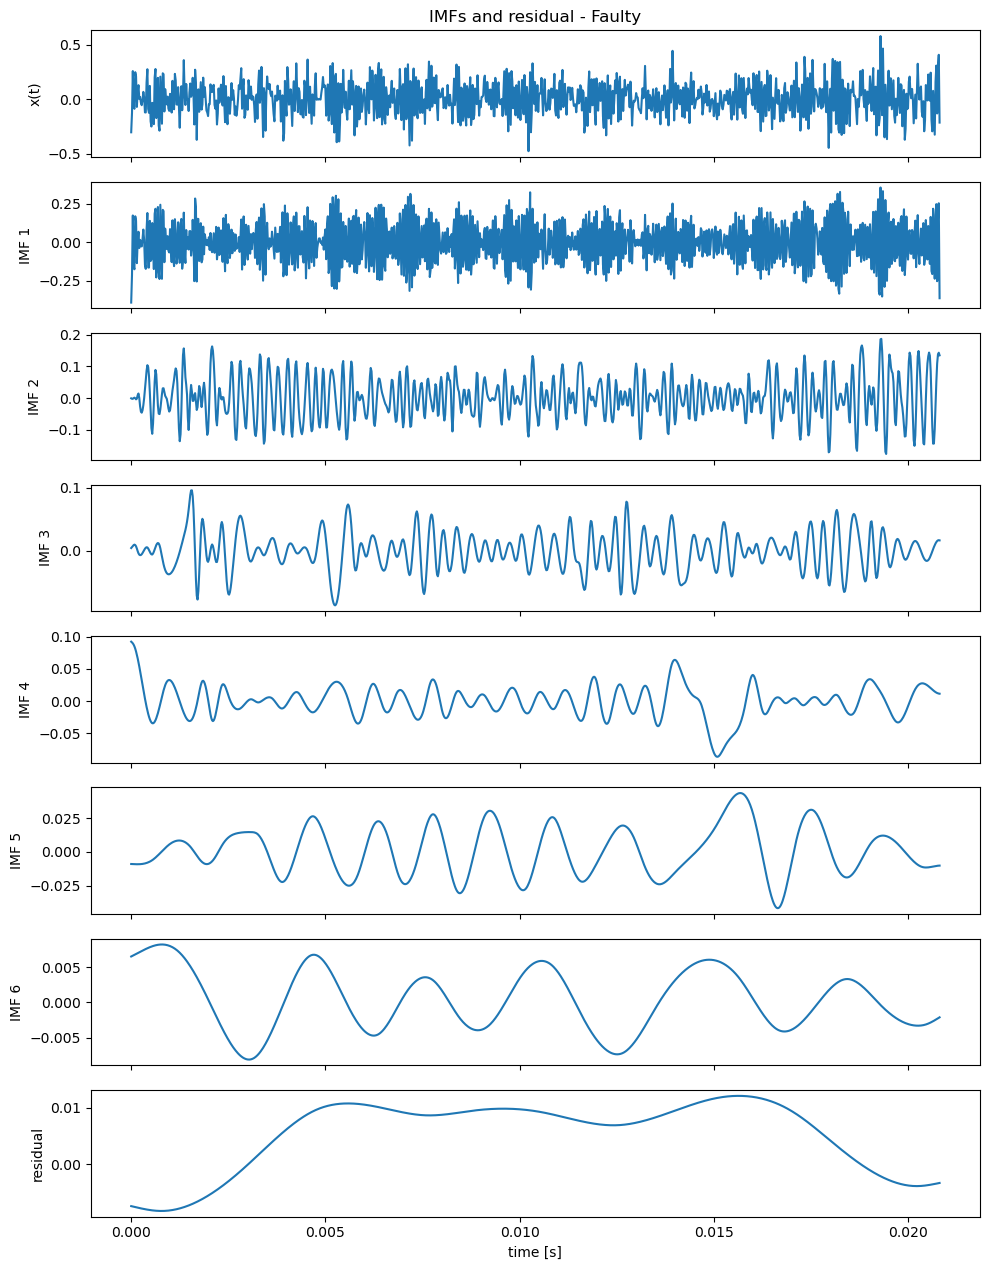

In [59]:
import matplotlib.pyplot as plt

K = len(imfs_faulty)
rows = K + 1 + (1 if residual_faulty is not None else 0)
fig, axs = plt.subplots(rows, 1, figsize=(10, 1.6*rows), sharex=True)
axs = np.atleast_1d(axs)

axs[0].plot(t, x_faulty)
axs[0].set_ylabel("x(t)")
axs[0].set_title('IMFs and residual - Faulty')

for i, imf in enumerate(imfs_faulty, start=1):
    axs[i].plot(t, imf)
    axs[i].set_ylabel(f"IMF {i}")

if residual_faulty is not None:
    axs[-1].plot(t, residual_faulty)
    axs[-1].set_ylabel("residual")

axs[-1].set_xlabel("time [s]")
fig.tight_layout()
plt.show()

# Feature Extraction

In [63]:
import numpy as np
from typing import Dict, List, Tuple, Optional
from scipy.stats import kurtosis, skew

try:
    from scipy.signal import hilbert as _hilbert
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

def _hilbert_analytic(x: np.ndarray) -> np.ndarray:
    if _HAVE_SCIPY:
        return _hilbert(x, axis=-1)
    # FFT-based fallback
    Xf = np.fft.fft(x, axis=-1)
    N = x.shape[-1]
    h = np.zeros(N)
    if N % 2 == 0:
        h[0] = h[N//2] = 1
        h[1:N//2] = 2
    else:
        h[0] = 1
        h[1:(N+1)//2] = 2
    return np.fft.ifft(Xf * h, axis=-1)

def _safe(x): 
    x = np.asarray(x)
    return x[np.isfinite(x)]

def _spec_at(f, F, A, bw_bins=1):
    """Amplitude around target freq f in FFT grid (median in ±bw_bins)."""
    if f <= 0 or f > F[-1]:
        return 0.0
    j = np.argmin(np.abs(F - f))
    j0 = max(0, j - bw_bins); j1 = min(len(F)-1, j + bw_bins)
    return float(np.median(A[j0:j1+1]))

def hht_feature_vector(result: Dict, fs: float,
                       t: Optional[np.ndarray] = None,
                       edge_trim: float = 0.02,
                       fmax: Optional[float] = None,
                       band_edges: Optional[List[Tuple[float,float]]] = None,
                       fault_freqs: Optional[Dict[str, float]] = None,
                       resonant_select: str = "top_energy",
                       resonant_k: int = 2) -> Tuple[np.ndarray, List[str]]:
    """
    Build an HHT feature vector from:
      result['imfs'], result['amplitude'], result['frequency'], result['residual'].
    Returns (X, feature_names).
    """
    imfs: List[np.ndarray] = result["imfs"]
    amp  = result["amplitude"]      # (K, N)
    freq = result["frequency"]      # (K, N)

    if len(imfs) == 0:
        return np.zeros(1), ["empty_hht"]

    N = amp.shape[1]
    if t is None:
        t = np.arange(N)/fs
    dt = np.median(np.diff(t))
    fmax = fmax if fmax is not None else 0.45*fs

    # masks: trim edges + valid Hz
    i0 = int(edge_trim*N); i1 = int((1-edge_trim)*N)
    mask = np.zeros_like(freq, dtype=bool)
    mask[:, i0:i1] = True
    mask &= np.isfinite(freq) & (freq >= 0) & (freq <= fmax) & np.isfinite(amp)

    # ---------- Per-IMF features ----------
    feats = []
    names = []
    K = len(imfs)
    total_energy = 1e-12 + np.sum((amp**2)*mask, dtype=float) * dt

    # amplitude-weighted center frequency to help resonant selection
    aw_center = np.zeros(K)
    per_imf_energy = np.zeros(K)

    for k in range(K):
        xk = imfs[k]
        mk = mask[k]
        ak = amp[k, mk]; fk = freq[k, mk]

        # time-domain
        rms = np.sqrt(np.mean(xk**2))
        cf  = np.max(np.abs(xk)) / (rms + 1e-12)
        kur = kurtosis(_safe(xk), fisher=False, bias=False)
        skw = skew(_safe(xk), bias=False)
        zcr = np.mean(np.diff(np.signbit(xk)) != 0)

        feats += [rms, cf, kur, skw, zcr]
        names += [f"imf{k+1}_rms", f"imf{k+1}_crest", f"imf{k+1}_kurt",
                  f"imf{k+1}_skew", f"imf{k+1}_zcr"]

        # Hilbert amplitude/frequency stats
        a_mean = np.mean(ak) if ak.size else 0.0
        a_std  = np.std(ak)  if ak.size else 0.0
        a_p95  = np.percentile(ak, 95) if ak.size else 0.0

        # amplitude-weighted frequency stats
        if ak.size:
            w = ak
            f_mean = float(np.sum(fk*w) / (np.sum(w) + 1e-12))
            f_std  = float(np.sqrt(np.sum(((fk - f_mean)**2)*w) / (np.sum(w) + 1e-12)))
        else:
            f_mean, f_std = 0.0, 0.0

        feats += [a_mean, a_std, a_p95, f_mean, f_std]
        names += [f"imf{k+1}_amp_mean", f"imf{k+1}_amp_std", f"imf{k+1}_amp_p95",
                  f"imf{k+1}_f_mean", f"imf{k+1}_f_std"]

        # energy and proportion
        Ek = float(np.sum((amp[k]**2)*mk) * dt)
        per_imf_energy[k] = Ek
        aw_center[k] = f_mean
        feats += [Ek, Ek/(total_energy)]
        names += [f"imf{k+1}_Hilbert_energy", f"imf{k+1}_energy_frac"]

    # ---------- Global Hilbert spectrum features ----------
    # Marginal spectrum via histogram
    F = freq[mask]
    W = (amp[mask]**2) * dt  # energy weights
    if F.size:
        nb = min(800, max(50, int(np.sqrt(F.size))))
        H, edges = np.histogram(F, bins=nb, range=(0, fmax), weights=W)
        Fm = 0.5*(edges[:-1] + edges[1:])
        Hn = H / (np.sum(H) + 1e-12)
        # moments
        centroid = float(np.sum(Fm*Hn))
        spread   = float(np.sqrt(np.sum(((Fm-centroid)**2)*Hn)))
        entropy  = float(-np.sum(Hn*np.log(Hn + 1e-12)))
        feats += [centroid, spread, entropy]
        names += ["hilbert_centroid", "hilbert_spread", "hilbert_entropy"]
        # optional band energies
        if band_edges:
            for i,(f1,f2) in enumerate(band_edges,1):
                m = (F >= f1) & (F < f2)
                feats.append(float(np.sum(W[m])/(total_energy)))
                names.append(f"band_{i}_{int(f1)}-{int(f2)}Hz_energy_frac")
    else:
        feats += [0.0, 0.0, 0.0]
        names += ["hilbert_centroid", "hilbert_spread", "hilbert_entropy"]

    # ---------- Resonant-IMF envelope spectrum (fault-rate features) ----------
    # pick resonant IMFs
    if K:
        if resonant_select == "top_energy":
            sel = np.argsort(per_imf_energy)[::-1][:max(1, resonant_k)]
        elif resonant_select == "high_freq":
            sel = np.argsort(aw_center)[::-1][:max(1, resonant_k)]
        else:  # custom list of indices
            sel = np.atleast_1d(resonant_select).astype(int)
            sel = sel[(sel>=0) & (sel<K)]
        y = np.sum([imfs[i] for i in sel], axis=0)
        env = np.abs(_hilbert_analytic(y))
        # FFT of envelope
        E = np.abs(np.fft.rfft(env))
        Fenv = np.fft.rfftfreq(len(env), d=dt)

        # summary peaks (top 5 below 0.5*fmax_env)
        mlim = int(0.5*len(Fenv))
        top_idx = np.argsort(E[:mlim])[::-1][:5]
        for j,idx in enumerate(top_idx,1):
            feats += [float(Fenv[idx]), float(E[idx])]
            names += [f"env_peak{j}_freq", f"env_peak{j}_amp"]

        # targeted fault frequencies (if provided)
        if fault_freqs:
            for key, f0 in fault_freqs.items():
                a0 = _spec_at(f0, Fenv, E, bw_bins=1)
                a2 = _spec_at(2*f0, Fenv, E, bw_bins=1)
                # local SNR vs ±5 bins
                j = np.argmin(np.abs(Fenv - f0))
                j0 = max(0, j-5); j1 = min(len(E)-1, j+5)
                noise = np.median(E[j0:j1+1])
                feats += [a0, a2, a0/(noise+1e-12)]
                names += [f"{key}_amp", f"{key}_2x_amp", f"{key}_snr"]
    return np.array(feats, dtype=float), names


In [73]:
faulty_faulty_df = faulty_df[(faulty_df['fault_diameter'] == 28) & (faulty_df['fault_element'] == 2)]

In [74]:
def windowed_hht_table(x, fs, win_s=0.2, step_s=0.05):
    L = int(round(win_s*fs)); S = int(round(step_s*fs))
    rows = []
    for i in range(0, len(x)-L+1, S):
        seg = x[i:i+L]
        res = hht.transform(seg, fs)          # HHT per window
        feats, names = hht_feature_vector(res, fs)  # ~85 features
        rows.append(feats)
    X = np.vstack(rows)        # shape: n_windows × ~85
    return X, names

X_healthy, names_healthy = windowed_hht_table(healthy_df['DE'].values, fs = 12000)
df_healthy = pd.DataFrame(data=X_healthy, columns=names_healthy)
X_faulty, names_faulty = windowed_hht_table(faulty_faulty_df['DE'].values, fs = 12000)
df_faulty = pd.DataFrame(data=X_faulty, columns=names_faulty)

In [77]:
df_healthy['fault'] = 0
df_healthy

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,fault
0,0.033480,3.651480,2.128131,0.050892,0.346811,0.045492,0.012946,0.065251,2035.611279,305.835087,...,148.820615,1065.0,19.718235,1035.0,15.127097,30.0,9.200608,1040.0,6.998422,0
1,0.033465,3.653121,2.046003,0.029255,0.347645,0.045679,0.012608,0.065202,2045.097070,293.546026,...,153.703193,1065.0,19.695581,1035.0,13.274396,1040.0,10.049104,30.0,9.240490,0
2,0.033945,3.601474,2.160996,0.052676,0.345561,0.045739,0.013577,0.066407,2022.455830,323.079776,...,153.449389,1065.0,17.418492,1035.0,16.365837,30.0,12.249828,1040.0,9.631789,0
3,0.034586,3.685999,2.246228,0.079293,0.347228,0.046914,0.014604,0.067842,2021.523588,325.814922,...,153.557600,1035.0,17.619956,1065.0,17.395974,30.0,12.226926,1040.0,8.966278,0
4,0.033392,3.819169,2.016579,0.037353,0.348479,0.045497,0.011823,0.063602,2057.590162,261.598429,...,149.252700,1035.0,18.690350,1065.0,15.930108,25.0,10.088687,30.0,8.060401,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0.033960,4.774961,2.712207,0.143475,0.348895,0.046167,0.014205,0.064132,2047.300500,281.902481,...,150.807734,1065.0,16.340206,1035.0,15.737538,30.0,14.260697,255.0,8.051191,0
802,0.033916,4.781222,2.696812,0.148876,0.348895,0.045792,0.013868,0.062255,2048.848106,277.659757,...,149.338976,1035.0,15.219263,30.0,13.615574,1065.0,13.420117,1095.0,8.864356,0
803,0.032185,2.615743,1.762267,-0.001863,0.350146,0.044477,0.010130,0.060552,2079.647195,209.572765,...,146.832172,1065.0,15.927131,1035.0,15.163420,30.0,14.170482,1095.0,9.491161,0
804,0.032548,4.044739,1.885618,0.033572,0.349729,0.044724,0.010254,0.060791,2072.470020,220.887019,...,146.678572,1065.0,15.431867,30.0,14.309553,1035.0,12.740903,1410.0,9.371614,0


In [78]:
df_faulty['fault'] = 1
df_faulty

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,fault
0,2.089167,4.287888,3.938249,-0.002276,0.514381,2.517043,1.574059,5.458073,3035.010951,280.946063,...,5968.175705,15.0,685.162770,35.0,671.743059,545.0,606.234714,25.0,588.065740,1
1,2.143196,3.507220,3.506826,-0.004260,0.514381,2.600419,1.563243,5.446164,3032.570479,276.061272,...,6244.086080,35.0,635.236828,545.0,630.694952,50.0,625.864412,135.0,557.102158,1
2,2.231731,3.368086,3.471961,-0.001524,0.509379,2.681501,1.671981,5.798360,3019.575112,277.281371,...,6435.141985,545.0,824.760894,35.0,818.118923,135.0,697.320157,60.0,597.525055,1
3,2.361270,3.282215,3.540094,0.001413,0.508545,2.817962,1.800967,6.189158,3013.614743,286.497098,...,6757.534893,545.0,959.237159,15.0,812.808133,35.0,706.879801,135.0,652.490602,1
4,2.355306,3.307458,3.564843,0.002753,0.506461,2.839133,1.825201,6.321058,2993.803034,294.385751,...,6687.868199,35.0,981.284747,545.0,921.352565,135.0,787.931332,15.0,762.633960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,1.898688,5.309438,4.655105,-0.004722,0.515215,2.221573,1.500941,4.981827,3030.207330,296.427960,...,5352.987153,5.0,773.456519,20.0,670.386251,35.0,559.947501,545.0,504.433766,1
194,2.007700,5.021151,4.201242,-0.000799,0.519800,2.452909,1.565401,5.249775,3057.829163,279.388601,...,5671.663009,35.0,918.908647,20.0,796.018635,5.0,648.143157,545.0,619.709251,1
195,2.160406,4.699642,4.303468,-0.004527,0.519383,2.587878,1.690461,5.540834,3050.722083,264.077149,...,6137.335728,35.0,1166.505067,15.0,712.453222,545.0,634.656213,50.0,539.089381,1
196,2.232404,4.548074,3.965451,-0.004678,0.520634,2.680685,1.733102,5.692800,3047.980479,266.647063,...,6367.182447,35.0,1103.868989,545.0,757.885675,15.0,734.128413,55.0,626.504764,1


In [80]:
df_overall = pd.concat((df_healthy,df_faulty))

In [82]:
df_overall = df_overall.sample(frac = 1)

In [97]:
names

['imf1_rms',
 'imf1_crest',
 'imf1_kurt',
 'imf1_skew',
 'imf1_zcr',
 'imf1_amp_mean',
 'imf1_amp_std',
 'imf1_amp_p95',
 'imf1_f_mean',
 'imf1_f_std',
 'imf1_Hilbert_energy',
 'imf1_energy_frac',
 'imf2_rms',
 'imf2_crest',
 'imf2_kurt',
 'imf2_skew',
 'imf2_zcr',
 'imf2_amp_mean',
 'imf2_amp_std',
 'imf2_amp_p95',
 'imf2_f_mean',
 'imf2_f_std',
 'imf2_Hilbert_energy',
 'imf2_energy_frac',
 'imf3_rms',
 'imf3_crest',
 'imf3_kurt',
 'imf3_skew',
 'imf3_zcr',
 'imf3_amp_mean',
 'imf3_amp_std',
 'imf3_amp_p95',
 'imf3_f_mean',
 'imf3_f_std',
 'imf3_Hilbert_energy',
 'imf3_energy_frac',
 'imf4_rms',
 'imf4_crest',
 'imf4_kurt',
 'imf4_skew',
 'imf4_zcr',
 'imf4_amp_mean',
 'imf4_amp_std',
 'imf4_amp_p95',
 'imf4_f_mean',
 'imf4_f_std',
 'imf4_Hilbert_energy',
 'imf4_energy_frac',
 'imf5_rms',
 'imf5_crest',
 'imf5_kurt',
 'imf5_skew',
 'imf5_zcr',
 'imf5_amp_mean',
 'imf5_amp_std',
 'imf5_amp_p95',
 'imf5_f_mean',
 'imf5_f_std',
 'imf5_Hilbert_energy',
 'imf5_energy_frac',
 'imf6_rms',
 '

## Test with Base XGBoost

In [83]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()

In [84]:
from sklearn.model_selection import train_test_split

In [86]:
df_overall.iloc[:, -1]

752    0
331    0
167    1
314    0
594    0
      ..
140    1
488    0
43     1
16     0
735    0
Name: fault, Length: 1004, dtype: int64

In [94]:
df_overall

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,fault
752,0.033282,3.890717,2.150580,0.011346,0.348479,0.045374,0.012965,0.063790,2047.897892,270.024805,...,151.002162,1065.0,19.184502,1035.0,17.863831,1040.0,9.894513,30.0,8.496987,0
331,0.034202,3.890354,2.356624,0.075833,0.346394,0.045978,0.014004,0.067237,2027.693667,313.509201,...,149.928304,1035.0,18.380683,1065.0,15.763898,30.0,10.015592,1040.0,9.233400,0
167,2.304716,3.889073,4.115457,0.004383,0.509379,2.693398,1.839082,6.223076,2999.222552,306.544130,...,6475.141388,15.0,1140.167178,35.0,1000.970594,25.0,760.652885,545.0,716.342910,1
314,0.033208,3.005788,1.975922,0.018499,0.346811,0.045521,0.011882,0.064091,2043.381639,288.456470,...,146.566746,1065.0,18.240910,1035.0,15.850491,30.0,11.449100,1040.0,10.517773,0
594,0.032193,2.453705,1.764544,-0.000370,0.350146,0.044636,0.009798,0.060339,2084.240527,186.831719,...,151.612625,1065.0,19.140724,1035.0,17.488723,30.0,10.545650,1095.0,8.839861,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2.106212,3.314086,3.340115,-0.004002,0.498124,2.554001,1.543808,5.417040,2947.515287,279.222164,...,6124.942168,20.0,900.741924,25.0,766.498517,50.0,564.828448,15.0,538.288143,1
488,0.032389,2.322202,1.799714,0.010768,0.350146,0.044658,0.010463,0.062617,2080.113940,207.477051,...,151.111514,1065.0,21.632530,1035.0,15.167052,25.0,9.252453,1040.0,9.182702,0
43,1.838045,4.144674,4.018699,-0.002126,0.505211,2.173195,1.418448,4.873580,2985.304704,309.693725,...,5205.560297,20.0,656.642537,50.0,586.806334,35.0,570.706451,85.0,513.890789,1
16,0.034124,4.472023,2.729275,-0.011129,0.346811,0.045736,0.015028,0.065803,2026.694627,310.309164,...,149.628797,1035.0,19.318551,30.0,14.277262,1065.0,13.128305,1010.0,9.390151,0


In [144]:
X = df_overall.iloc[:, :-1]
y = df_overall.iloc[:, -1]

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [146]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [147]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

In [148]:
xgbc.predict_proba(X_train)[:, 1]

array([0.00153338, 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.00153338, 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.993937  , 0.00153338, 0.00153338, 0.993937  , 0.00153338,
       0.00153338, 0.00153338, 0.993937  , 0.00153338, 0.00153338,
       0.00153338, 0.993937  , 0.00153338, 0.00153338, 0.00153338,
       0.00153338, 0.00153338, 0.00153338, 0.993937  , 0.00153338,
       0.00153338, 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.00153338, 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.993937  , 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.993937  , 0.00153338, 0.00153338, 0.00153338, 0.993937  ,
       0.00153338, 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.00153338, 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.993937  , 0.00153338, 0.00153338, 0.00153338, 0.00153338,
       0.00153338, 0.00153338, 0.00153338, 0.993937  , 0.00153338,
       0.00153338, 0.00153338, 0.993937  , 0.00153338, 0.99393

In [149]:
fpr_train, tpr_train, _ = roc_curve(y_train, xgbc.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, thrs = roc_curve(y_test, xgbc.predict_proba(X_test)[:, 1])

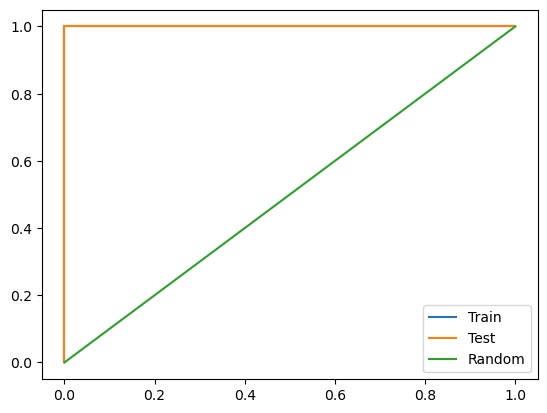

In [150]:
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.plot(fpr_train, fpr_train, label = 'Random')
plt.legend()

In [151]:
thrs

array([       inf, 0.993937  , 0.00153338], dtype=float32)

In [152]:
best_thr = thrs[np.argmax(tpr_test-fpr_test)]
best_thr

0.993937

In [153]:
print("F1 Score: ", f1_score(y_test, np.where(xgbc.predict_proba(X_test)[:, 1] >= best_thr, 1, 0)))
print("Accuracy Score: ", accuracy_score(y_test, np.where(xgbc.predict_proba(X_test)[:, 1] >= best_thr, 1, 0)))
print("Precision Score: ", precision_score(y_test, np.where(xgbc.predict_proba(X_test)[:, 1] >= best_thr, 1, 0)))
print("Recall Score: ", recall_score(y_test, np.where(xgbc.predict_proba(X_test)[:, 1] >= best_thr, 1, 0)))
print("ROC AUC Score: ", roc_auc_score(y_test, np.where(xgbc.predict_proba(X_test)[:, 1] >= best_thr, 1, 0)))

F1 Score:  1.0
Accuracy Score:  1.0
Precision Score:  1.0
Recall Score:  1.0
ROC AUC Score:  1.0


In [154]:
xgbc.feature_importances_.flatten()

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [155]:
pd.options.display.max_columns = 100

In [156]:
pd.DataFrame(data = xgbc.feature_importances_.reshape(1, -1), columns = names)

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,imf1_Hilbert_energy,imf1_energy_frac,imf2_rms,imf2_crest,imf2_kurt,imf2_skew,imf2_zcr,imf2_amp_mean,imf2_amp_std,imf2_amp_p95,imf2_f_mean,imf2_f_std,imf2_Hilbert_energy,imf2_energy_frac,imf3_rms,imf3_crest,imf3_kurt,imf3_skew,imf3_zcr,imf3_amp_mean,imf3_amp_std,imf3_amp_p95,imf3_f_mean,imf3_f_std,imf3_Hilbert_energy,imf3_energy_frac,imf4_rms,imf4_crest,imf4_kurt,imf4_skew,imf4_zcr,imf4_amp_mean,imf4_amp_std,imf4_amp_p95,imf4_f_mean,imf4_f_std,imf4_Hilbert_energy,imf4_energy_frac,imf5_rms,imf5_crest,imf5_kurt,imf5_skew,imf5_zcr,imf5_amp_mean,imf5_amp_std,imf5_amp_p95,imf5_f_mean,imf5_f_std,imf5_Hilbert_energy,imf5_energy_frac,imf6_rms,imf6_crest,imf6_kurt,imf6_skew,imf6_zcr,imf6_amp_mean,imf6_amp_std,imf6_amp_p95,imf6_f_mean,imf6_f_std,imf6_Hilbert_energy,imf6_energy_frac,hilbert_centroid,hilbert_spread,hilbert_entropy,env_peak1_freq,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
from sklearn.tree import DecisionTreeClassifier

In [158]:
dtc = DecisionTreeClassifier(max_depth=3)

In [159]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

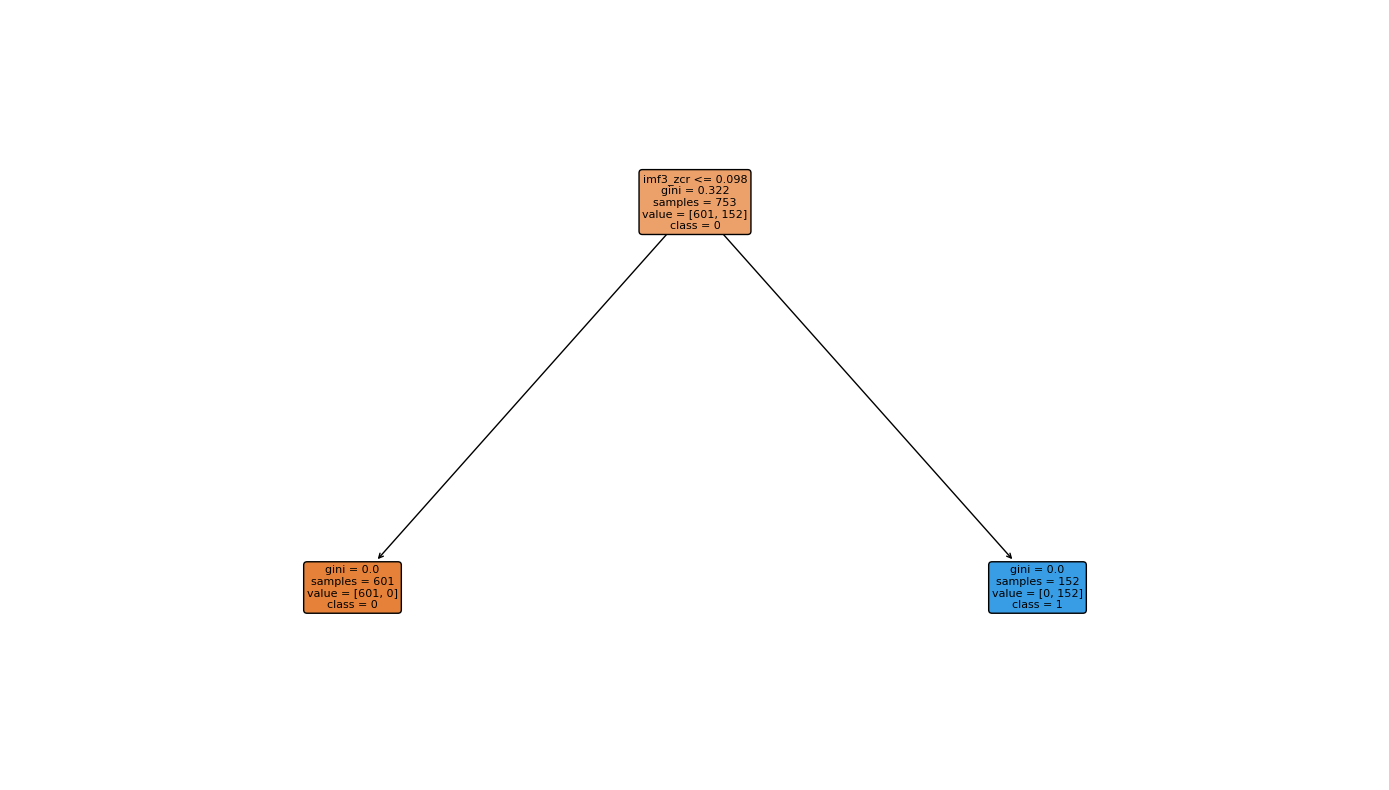

In [160]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(14, 8))
plot_tree(
    dtc,
    feature_names=list(X_train.columns),
    class_names=[str(c) for c in dtc.classes_],  # omit for regressor
    filled=True, rounded=True, fontsize=8
)
plt.tight_layout()
plt.show()
# Save:
# plt.savefig("tree.png", dpi=200, bbox_inches="tight")


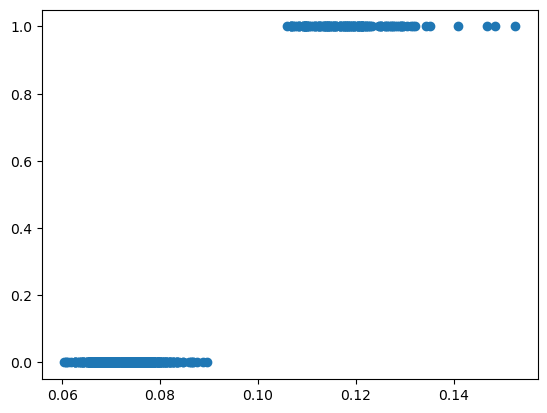

In [161]:
plt.scatter(X_train['imf3_zcr'], y_train)